In [3]:
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import cv2
import torch
import torch.nn as nn
from torchvision import models, transforms
from ultralytics import YOLO
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
import time
import csv
import os


0: 480x640 2 persons, 22.2ms
Speed: 3.2ms preprocess, 22.2ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 13.5ms
Speed: 2.3ms preprocess, 13.5ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 13.0ms
Speed: 3.5ms preprocess, 13.0ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 22.0ms
Speed: 3.4ms preprocess, 22.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 tie, 14.1ms
Speed: 2.5ms preprocess, 14.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 2.0ms postprocess per image at 

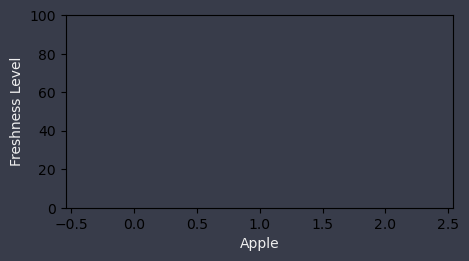

In [6]:
 

# Load YOLO model for detection
yolo_model = YOLO('yolov8n.pt')  # Update with your local model path

# Load EfficientNet for classification
def load_efficientnet_model(checkpoint_path, num_classes=3):
    model = models.efficientnet_b0(weights="IMAGENET1K_V1")
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

efficientnet_model = load_efficientnet_model('efficientnet_apple50.pt')

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# COCO class names
COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat',
    'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'TV', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Classify apple freshness
def classify_apple(image, model):
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

# Save apple freshness data to CSV
def save_to_csv(freshness_data):
    file_exists = os.path.isfile('freshness.csv')
    with open('freshness.csv', 'a', newline='') as csvfile:
        fieldnames = ['Apple_ID', 'Freshness', 'Shelf_Life']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()  # Write header only if file doesn't exist
        
        for i, freshness in enumerate(freshness_data):
            timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
            shelf_life = "2 weeks" if freshness == 0 else "4 days" if freshness == 1 else "0 days"
            writer.writerow({'Apple_ID': timestamp, 'Freshness': {0: 'Fresh', 1: 'Ripe', 2: 'Rotten'}[freshness], 'Shelf_Life': shelf_life})

# GUI Application Class
class AppleFreshnessApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Apple Freshness Detection")
        self.root.geometry("1200x800")  # Slightly larger window
        self.root.configure(bg="#282C34")  # Dark theme background

        # Set frame style for uniform UI
        frame_bg = "#383C4A"
        widget_fg = "#F0F0F0"

        # Create a main frame to hold all elements
        self.main_frame = tk.Frame(self.root, bg=frame_bg)
        self.main_frame.pack(fill="both", expand=True, padx=10, pady=10)

        # Camera feed frame (vertically larger)
        self.camera_frame = tk.Frame(self.main_frame, bg=frame_bg, width=700, height=600)
        self.camera_frame.grid(row=0, column=0, rowspan=2, padx=10, pady=10, sticky="nsew")

        self.video_label = tk.Label(self.camera_frame, bg=frame_bg, fg=widget_fg, text="Camera Feed", font=("Helvetica", 12))
        self.video_label.pack(fill="both", expand=True)

        # Frame to hold the bar chart (top right)
        self.graph_frame = tk.Frame(self.main_frame, bg=frame_bg)
        self.graph_frame.grid(row=0, column=1, padx=10, pady=10, sticky="nsew")

        # Bar chart for freshness levels
        self.fig, self.ax = plt.subplots(figsize=(5, 2.5), facecolor=frame_bg)
        self.ax.set_facecolor(frame_bg)
        self.bar_chart = FigureCanvasTkAgg(self.fig, master=self.graph_frame)
        self.bar_chart.get_tk_widget().pack(pady=10, padx=10)

        # Table for shelf life information (bottom right)
        self.table_frame = tk.Frame(self.main_frame, bg=frame_bg)
        self.table_frame.grid(row=1, column=1, padx=10, pady=10, sticky="nsew")

        # Shelf life table with bold headings
        self.shelf_life_table = ttk.Treeview(self.table_frame, columns=("Apple", "Shelf Life"), show="headings", height=5)
        self.shelf_life_table.heading("Apple", text="Apple")
        self.shelf_life_table.heading("Shelf Life", text="Shelf Life")
        self.shelf_life_table.column("Apple", anchor='center')
        self.shelf_life_table.column("Shelf Life", anchor='center')
        self.shelf_life_table.pack(pady=5, padx=5)

        # Customize table style (bold headings)
        style = ttk.Style()
        style.configure("Treeview.Heading", font=("Helvetica", 10, "bold"), background="#4CAF50", foreground="black")  # Change foreground to 'black'
        style.configure("Treeview", rowheight=30, font=("Helvetica", 10), background="#f9f9f9", foreground="#000000", fieldbackground="#f9f9f9")
        # Save button for saving results
        save_button = tk.Button(self.main_frame, text="Save Results", font=("Helvetica", 12), bg="#4CAF50", fg="white", command=self.save_results)
        save_button.grid(row=2, column=0, padx=10, pady=10)

        # Start capturing the video feed
        self.cap = cv2.VideoCapture(0)
        self.update()

    def plot_freshness(self, freshness_data):
        # Clear previous plot
        self.ax.clear()

        # X and Y data for the bar chart
        labels = [f"Apple {i+1}" for i in range(len(freshness_data))]
        values = [100 if f == 0 else 60 if f == 1 else 10 for f in freshness_data]

        # Assign colors based on freshness: Green for fresh, Orange for ripe, Red for rotten
        colors = ['#4CAF50' if f == 0 else '#FF9800' if f == 1 else '#F44336' for f in freshness_data]

        # Plot the bar chart
        self.ax.bar(labels, values, color=colors)
        self.ax.set_ylim([0, 100])
        self.ax.set_ylabel("Freshness Level", fontsize=10, color="#F0F0F0")
        self.ax.set_xlabel("Apple", fontsize=10, color="#F0F0F0")

        # Redraw the canvas
        self.bar_chart.draw()

    def update_shelf_life_table(self, freshness_data):
        # Clear existing table content
        for row in self.shelf_life_table.get_children():
            self.shelf_life_table.delete(row)

        # Add shelf life information for each apple
        for i, freshness in enumerate(freshness_data):
            shelf_life = "2 weeks" if freshness == 0 else "4 days" if freshness == 1 else "0 days"
            self.shelf_life_table.insert("", "end", values=(f"Apple {i+1}", shelf_life))

    def update(self):
        ret, frame = self.cap.read()
        if ret:
            frame = cv2.flip(frame, 1)  # Mirror the image
            results = yolo_model(frame, conf=0.3)
            detections = results[0].boxes
            detected_classes = detections.cls.cpu().numpy()
            detected_class_names = [COCO_CLASSES[int(cls)] for cls in detected_classes]

            apple_detections = []  # List to store detected apples

            for i in range(len(detections)):
                xyxy = detections.xyxy[i].cpu().numpy()
                class_name = detected_class_names[i]
                if class_name == "apple":
                    apple_detections.append(xyxy)

            freshness_data = []  # To hold freshness classification results
            if len(apple_detections) > 0:
                for idx, xyxy in enumerate(apple_detections):
                    x1, y1, x2, y2 = map(int, xyxy)
                    apple_crop = frame[y1:y2, x1:x2]
                    apple_crop_pil = Image.fromarray(cv2.cvtColor(apple_crop, cv2.COLOR_BGR2RGB))
                    label = classify_apple(apple_crop_pil, efficientnet_model)
                    freshness_data.append(label)

                    # Draw bounding box around the apple with correct color
                    label_text = {0: "Fresh", 1: "Ripe", 2: "Rotten"}[label]
                    colors = {0: (0, 255, 0), 1: (255, 165, 0), 2: (255, 0, 0)}  # Fresh: Green, Ripe: Orange, Rotten: Red
                    cv2.rectangle(frame, (x1, y1), (x2, y2), colors[label], 2)
                    cv2.putText(frame, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

                # Update the bar chart and shelf life table with freshness data
                self.plot_freshness(freshness_data)
                self.update_shelf_life_table(freshness_data)
                save_to_csv(freshness_data)  # Save freshness data to CSV
            else:
                # If no apples are detected, clear the bar chart and table
                self.plot_freshness([])
                self.update_shelf_life_table([])

            # Convert frame to Tkinter image
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            imgtk = ImageTk.PhotoImage(image=img)
            self.video_label.imgtk = imgtk
            self.video_label.configure(image=imgtk)

        # Recursively call update to keep fetching frames
        self.root.after(10, self.update)

    def save_results(self):
        ret, frame = self.cap.read()
        if ret:
            file_name = filedialog.asksaveasfilename(defaultextension=".jpg", filetypes=[("JPEG", "*.jpg"), ("PNG", "*.png")])
            if file_name:
                cv2.imwrite(file_name, frame)
                messagebox.showinfo("Success", "Image saved successfully!")

    def on_closing(self):
        self.cap.release()
        self.root.destroy()

# Initialize Tkinter window
root = tk.Tk()
app = AppleFreshnessApp(root)
root.protocol("WM_DELETE_WINDOW", app.on_closing)
root.mainloop()
